# Reinforcement learning
Reinforcement learning on the pyworld3 model. The goal is to get a reinforcement learning agent to improve upon the standard run and thens tudy what controls were implemented for the improved run. With improving on the standard run we mean that one aspect of it performs better according to some predefined reward function. \
Training data can be obtained by running data_generation.py

In [1]:
import numpy as np
from pyworld3 import World3
from matplotlib import pyplot as plt
import pandas as pd
from tqdm import tqdm

## Data extraction and training of neural net
This assumes that there is some file with rewards J and states stored for randomized runs.

In [20]:
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

max_year = 2100
filepath = "data_reward_HSDI.parquet"
df = pd.read_parquet(filepath)
state_variables = df.columns[df.columns != "J"]

world_reference = World3(year_max=max_year)
world_reference.set_world3_control()
world_reference.init_world3_constants()
world_reference.init_world3_variables()
world_reference.set_world3_table_functions()
world_reference.set_world3_delay_functions()
world_reference.run_world3(fast=True)

def reward_func(world, k=None):
    # needs to be the same as data_file
    # le: life expectancy
    # j/pop: determine unemployment, a high value is seeked and would simule a low global unemployment, will substitute for education
    # sopc: service output per capital [dollars/person-year], will substitute for GNP
    # ppol/pop: persistent pollution per capita

    # le
    min_le = 20
    max_le = 85

    # j/pop
    min_jpop = 0
    max_jpop = 1

    # sopc
    min_sopc = np.min(world_reference.sopc)
    max_sopc = np.max(world_reference.sopc)

    # ppol/pop
    min_ppol_pop = 0
    max_ppol_pop = 1

    if k is not None:
        I_le = (world.le[k] - min_le) / (max_le - min_le)
        I_le = np.clip(I_le, 0, 1)      # keeps the index between 0 and 1

        jpop = world.j[k]/world.pop[k]
        jpop = np.clip(jpop, 0, 1)
        I_jpop = (jpop - min_jpop) / (max_jpop - min_jpop)

        I_sopc = (world.sopc[k] - min_sopc) / (max_sopc - min_sopc)
        I_sopc = np.clip(I_sopc, 0, 1)
    
        ppol_pop = world.ppol[k] / world.pop[k]
        ppol_pop = np.clip(ppol_pop, 0, 1)
        I_ppol_pop = (1 - ((ppol_pop - min_ppol_pop) / (max_ppol_pop - min_ppol_pop)))

        HSDI = (I_le * I_jpop * I_sopc * I_ppol_pop)**(1/4)

        return HSDI
    else: 
        I_le = (world.le - min_le) / (max_le - min_le)
        I_le = np.clip(I_le, 0, 1)      # keeps the index between 0 and 1

        jpop = world.j/world.pop
        jpop = np.clip(jpop, 0, 1)
        I_jpop = (jpop - min_jpop) / (max_jpop - min_jpop)

        I_sopc = (world.sopc - min_sopc) / (max_sopc - min_sopc)
        I_sopc = np.clip(I_sopc, 0, 1)
    
        ppol_pop = world.ppol / world.pop
        ppol_pop = np.clip(ppol_pop, 0, 1)
        I_ppol_pop = 1 - ((ppol_pop - min_ppol_pop) / (max_ppol_pop - min_ppol_pop))

        HSDI = (I_le * I_jpop * I_sopc * I_ppol_pop)**(1/4)
        return HSDI


    """
    # le: life expactancy [years], want a high value
    # j/pop: determine unemployment, a high value is önskvärt and would simule a low global unemployment
    # d1: deaths per year, ages 0-14 [persons/year], should simulate infants deaths, wants a low value therefore using a minustecken 

    # Collect max-values from standard run for le, j/pop, -d1 (minustecken pga tvinga att vi vill att den är låg)
    max_le_standard = np.max(world_reference.le)
    max_jpop_standard = np.max(world_reference.j / world_reference.pop)
    max_d1_standard = np.max(world_reference.d1)

    # Create HDI
    if k is not None:
        jpop = world.j[k]/world.pop[k]
        HDI = ((world.le[k]/max_le_standard) + (jpop/max_jpop_standard) - (world.d1[k]/max_d1_standard)) / 3
        return HDI
    else:
        jpop = world.j/world.pop
        HDI = ((world.le/max_le_standard) + (jpop/max_jpop_standard) - (world.d1/max_d1_standard)) / 3
        return HDI """



In [21]:
class neuralNet(nn.Module):
    def __init__(self, in_dim, out_dim):
        # 2 hidden layers
        super(neuralNet, self).__init__()
        self.input_layer = nn.Linear(in_features=in_dim+1, out_features=64)
        self.hidden_layer1 = nn.Linear(in_features=64, out_features=64) 
        self.hidden_layer2 = nn.Linear(in_features=64, out_features=32)
        self.outLayer = nn.Linear(in_features=32, out_features=out_dim)

    def forward(self, x):
        # forward pass with relu activation function
        ones = torch.ones((x.shape[0], 1))
        x = torch.cat((x, ones), dim=1)
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.outLayer(x)
        return x

### Preprocessing
Preprocessing is a 80, 20 training test split. \
Normalizing data by setting mean to zero and variance to one for each variable.

In [22]:
X = df.drop(columns=["J"]).to_numpy()
J = df["J"].to_numpy().reshape(-1,1)

X_train, X_test, J_train, J_test = train_test_split(X, J, test_size=0.2, random_state=42)

# normalizing
X_normalizer = StandardScaler()
X_train = X_normalizer.fit_transform(X_train)
X_test = X_normalizer.transform(X_test)
J_normalizer = StandardScaler()
J_train = J_normalizer.fit_transform(J_train)
J_test = J_normalizer.transform(J_test)

# turning into pytorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
J_train = torch.tensor(J_train, dtype=torch.float32)
J_test = torch.tensor(J_test, dtype=torch.float32)

### Training and creating a function

100%|██████████| 300/300 [00:18<00:00, 16.39it/s]


Error on test set: 0.015996262431144714


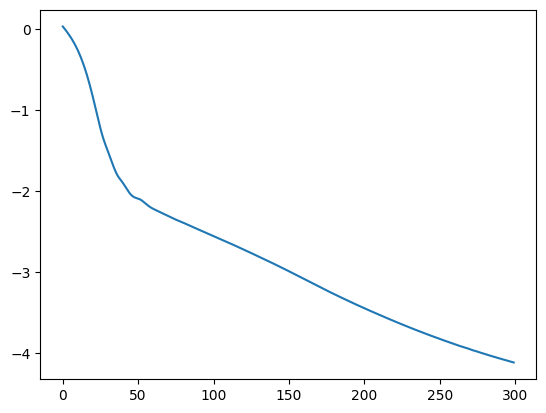

In [23]:
model = neuralNet(X_train.shape[1], 1)
loss_func = nn.MSELoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Optimizing weights

epochs = 300
losses = np.zeros((epochs,1))
model.train()

for epoch in tqdm(range(epochs)):
    J_pred = model.forward(X_train)
    loss = loss_func(J_pred, J_train)

    optimizer.zero_grad() 
    loss.backward() 
    optimizer.step() 
    losses[epoch] = loss.item()

model.eval()

with torch.no_grad():
    J_pred = model.forward(X_test)
    loss = loss_func(J_pred, J_test)

    print("Error on test set:", loss.item())

plt.plot(np.log(losses))

In [24]:
def nn_func(model, world, k):
    """ 
    model: neural network model
    world: World3 object
    k: current iteration

    Returns
        J_hat
    """
    model.eval()
    state = np.array([getattr(world, var)[k] for var in state_variables])
    state = X_normalizer.transform(state.reshape(1, -1))
    state = torch.tensor(state, dtype=torch.float32)
    with torch.no_grad():
        J_ = model.forward(state)
    return J_.item()

### Loss comparison
Want to compare the loss, which is the difference between J_hat and J. The loss should be plotted against time, and a good results should be close to an constant.

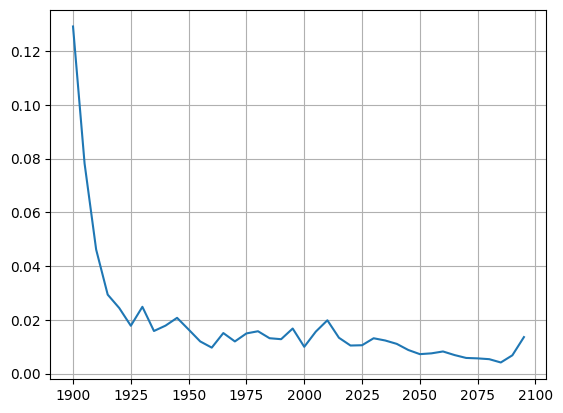

In [25]:
# de-transform to right size (numpy)
X_numpy = X_normalizer.inverse_transform(X_test.numpy())
J_numpy = J_test.numpy()

time_index = state_variables.get_loc('time')
errors = []
years = []

for year in range(1900, 2100, 5):
    condition = (X_numpy[:, time_index] < year+5) & (X_numpy[:, time_index] >= year)  # all rows where the condition is true
    row_indices = np.where(condition)[0]

    X_rows =  X_normalizer.transform(X_numpy[row_indices,:])

    model.eval()
    with torch.no_grad():
        J_pred = model.forward(torch.tensor(X_rows, dtype=torch.float32))
    error = np.sum((J_pred.numpy() - J_numpy[row_indices])**2) / row_indices.size
    errors.append(error)
    years.append(year)

plt.plot(years, errors)
plt.grid()
plt.show()


## Optimization

In [ ]:
class Controller_NN(nn.module):
    def __init__(self, in_dim):
        super(neuralNet, self).__init__()
        self.input_layer = nn.Linear(in_features=in_dim+1, out_features=64)
        self.hidden_layer1 = nn.Linear(in_features=64, out_features=64) 
        self.hidden_layer2 = nn.Linear(in_features=64, out_features=32)
        self.outLayer = nn.Sigmoid(in_features=32, out_features=2) 

    def forward(self):
        ones = torch.ones((x.shape[0], 1))
        x = torch.cat((x, ones), dim=1)
        x = torch.relu(self.input_layer(x))
        x = torch.relu(self.hidden_layer1(x))
        x = torch.relu(self.hidden_layer2(x))
        x = self.outLayer(x)
        return x


In [ ]:
def loop0(world):
    world.redo_loop = True
    while world.redo_loop:  # unsorted updates at initialization only
        world.redo_loop = False
        world.loop0_population()
        world.loop0_capital()
        world.loop0_agriculture()
        world.loop0_pollution()
        world.loop0_resource()
    
def generate_control(agent, world3, k, steps, J_hat, num_controls=10, training=True):
    state = np.array([getattr(world3, var)[k] for var in state_variables])
    control = agent(state)
    n = world3.n
    steps = min(steps,n-k)
    world3.fioac_control = control[0]
    world3.isopc_control = control[1]
    reward = 0
    for k_new in range(k,k+steps):
        world3._loopk_world3_fast(k_new-1, k_new, k_new-1, k_new)
        if k_new != k+steps-1:
            reward += reward_func(world3, k_new)
        else:
            J_val = np.array(J_hat(world3, k_new)).reshape(-1,1)
            J_val = J_normalizer.inverse_transform(J_val)[0,0]
            reward += J_val
            # spara reward och kontroll 

    # returnera bästa rewarden och kontrollen
    return


def generate_fioac_control_values(world3, k):
    current_value = world3.fioac_control(k-1)
    lower_bound = max(current_value - 0.2, 0)   # Ensure the minimum value is at least 0
    upper_bound = min(current_value + 0.2, 1)   # Ensure that the maximum value is at least 0
    return np.linspace(lower_bound, upper_bound, 5)

def generate_isopc_control_values(world3, k):
    current_value = world3.isopc_control(k-1)
    lower_bound = max(current_value - 0.2, 0.01)   # Ensure the minimum value is at least 0,01 to avoid div with zero
    upper_bound = min(current_value + 0.2, 2)
    return np.linspace(lower_bound, upper_bound, 5)


def get_control(world3, k, steps, J_hat):
    """ 
    In:
        world3: pyworld3 simulation
        k: current iteration
        steps: how many steps to look ahead
        J_hat: Approximation of J function
    Returns:
        control: fioac control value, isopc control value
    """
    # _self._loopk_world3_fast(k_ - 1, k_, k_ - 1, k_)  # sorted updates
    n = world3.n
    steps = min(steps,n-k)
    
    best_J = -np.inf
    fioac_controls = generate_fioac_control_values(world3, k)
    isopc_controls = generate_isopc_control_values(world3, k)

    for val in fioac_controls:
        for val2 in isopc_controls:
            reward = 0
            world3.fioac_control = lambda _: val
            world3.isopc_control = lambda _: val2
            for k_new in range(k,k+steps):
                world3._loopk_world3_fast(k_new-1, k_new, k_new-1, k_new)
                if k_new != k+steps-1:
                    reward += reward_func(world3, k_new)
                else:
                    J_val = np.array(J_hat(world3, k_new)).reshape(-1,1)
                    J_val = J_normalizer.inverse_transform(J_val)[0,0]
                    reward += J_val
            if reward > best_J:
                best_J = reward
                fioac_val = val
                isopc_val = val2
    return fioac_val, isopc_val

def J_func(reward):
    """ 
    In:
        reward - numpy array: rewards for the simlation
    Out: 
        Array of J function values
    
    Computes the cumulative reward for each step onwards
    """
    iterations = reward.shape[0]
    J = np.zeros((iterations,1))
    J[iterations-1] = reward[iterations-1]
    for k in range(2,iterations+1):
        # J[n] is the reward at step n plus J[n+1]
        J[iterations-k] = reward[iterations-k] + J[iterations-k+1] 
    return J

In [ ]:
world_control = World3(year_max=max_year)
world_control.set_world3_control()
world_control.init_world3_constants()
world_control.init_world3_variables()
world_control.set_world3_table_functions()
world_control.set_world3_delay_functions()


# loop0 first
loop0(world_control)
isopc_val = 1 # change?

for k in range(1,world_control.n):
    if k % 10 == 0 and world_control.time[k] >= 1980:
        J_hat = lambda world, k: nn_func(model, world, k)
        fioac_val, isopc_val = get_control(world_control, k, 20, J_hat)
        world_control.fioac_control = lambda _: fioac_val
        world_control.isopc_control = lambda _: isopc_val
        world_control.isopc_control_values[k] = isopc_val
        world_control._loopk_world3_fast(k -1, k, k-1, k)
        # träna agent här
    else:
        world_control._loopk_world3_fast(k -1, k, k-1, k)
        world_control.isopc_control_values[k] = isopc_val
        

### Results

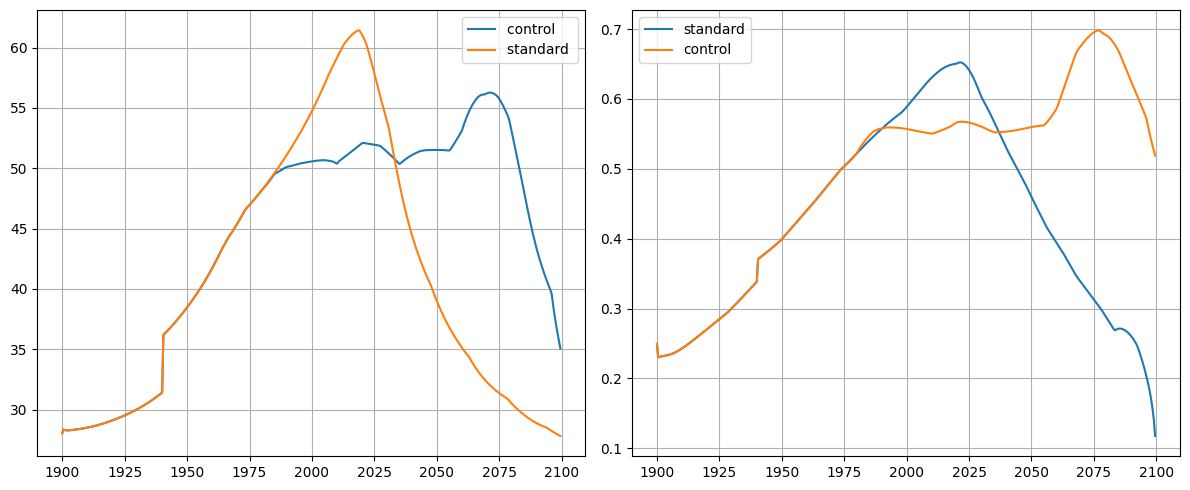

(None, <matplotlib.legend.Legend at 0x1ed08745700>, None, None)

In [29]:
import matplotlib.pyplot as plt
start = 0
end = -1
plt.figure(figsize=(12, 5)), plt.subplot(1, 2, 1)
#plt.plot(world_reference.time[start:end], world_reference.fioac[start:end], label="standard fioac")
plt.plot(world_control.time[start:end], world_control.le[start:end], label="control ")
plt.plot(world_reference.time[start:end], world_reference.le[start:end], label="standard ")
#plt.plot(world_control.time[start:end], world_control.nr[start:end], label="control isopc")
plt.grid(), plt.legend(), plt.subplot(1, 2, 2)
plt.plot(world_reference.time[start:end], reward_func(world_reference)[start:end], label="standard")
plt.plot(world_control.time[start:end], reward_func(world_control)[start:end], label="control")
#plt.plot(world_reference.time[start:end], world_reference.ppol[start:end], label="standard")
#plt.plot(world_control.time[start:end], world_control.ppol[start:end], label="control")
plt.grid(), plt.legend(), plt.tight_layout(), plt.show()

Plot of the rewards for the control run. Neural network for the control run and standard run starting from each state in the control run but with standard run instead.

In [30]:
def standard_run_from(world, k):
    initial_state = {}
    for var in state_variables:
        if var == "time":
            continue
        val = getattr(world, var)[k]
        initial_state[var+"i"] = val

    world_temp = World3(year_max=max_year, year_min=world.time[k])
    world_temp.set_world3_control()
    world_temp.init_world3_constants(**initial_state)
    world_temp.init_world3_variables()
    world_temp.set_world3_table_functions()
    world_temp.set_world3_delay_functions()
    world_temp.run_world3(fast=True)

    J_ = J_func(reward_func(world_temp)) # this can probably be more dynamic
    return J_[0] # only want the first value

In [31]:
time = world_control.time

J_control = J_func(reward_func(world_control)) # This can probably be more dynamic
J_standard = J_func(reward_func(world_reference))
nn_control = np.zeros((world_control.n,1))
nn_standard = np.zeros((world_reference.n,1))
standard_on_control = np.zeros((world_control.n,1))

for k in range(0, world_control.n):
    standard_on_control[k] = standard_run_from(world_control, k)
    nn_control[k] = nn_func(model, world_control, k)
    nn_standard[k] = nn_func(model, world_reference, k)

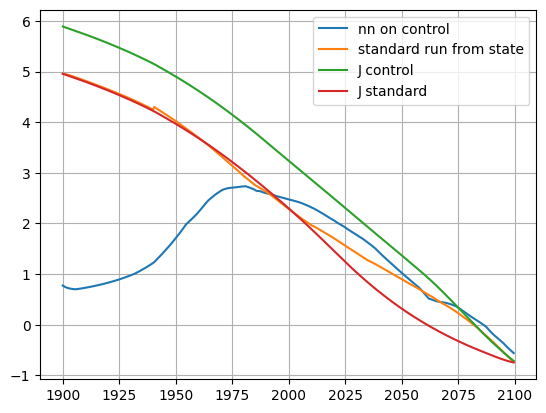

In [32]:
start = 0
end = -1

plt.plot(time[start:end], nn_control[start:end], label="nn on control")
plt.plot(time[start:end], J_normalizer.transform(standard_on_control)[start:end], label="standard run from state")
# plt.plot(time, nn_standard, label="nn on standard")
plt.plot(time[start:end], J_normalizer.transform(J_control)[start:end], label="J control")
plt.plot(time[start:end], J_normalizer.transform(J_standard)[start:end], label="J standard")
plt.legend()
plt.grid()
plt.show()

*Comments* the control does perform better, but it performs rather bad at the end. Might be because he training data there is bad. The control also needs a very long look ahead to do anything useful